# Graphical Analysis of GitHub Repositories and Contributors

In this notebook, we programatically view the connections between open source projects, determine project clusters, and map out technology ecosystems. We explore the Augur GitHub data to view relationships between open source projects and communities by studying graphs based on relations such as common contributors and project activities between different GitHub repositories.

## Connect to Augur database

Until the Operate First enviroment can connect to the DB, use config file to access. Do not push config file to Github repo

In [1]:
import psycopg2
import pandas as pd
import collections
from functools import reduce

import sqlalchemy as salc
import json
import os
import networkx as nx
import matplotlib.pyplot as plt

with open("../../../config.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Get all the Data, Build all the Graphs

In [3]:
# Subset repositories based on a category
# Selecting repositories that fall under the Containers org on Github
def filtered_deps(group_name: str) -> str: 
    science_repo_sql = salc.sql.text(f"""
                     SET SCHEMA 'augur_data';
                        SET SCHEMA 'augur_data';
                        SELECT
                        	A.repo_id,
                        	dep_name,
                        	number 
                        FROM
                        	(
                        	SELECT
                        		augur_data.repo_dependencies.dep_name,
                        		augur_data.repo_dependencies.repo_id,
                        		COUNT ( * ) AS number 
                        	FROM
                        		augur_data.repo_dependencies 
                        	GROUP BY
                        		augur_data.repo_dependencies.dep_name,
                        		augur_data.repo_dependencies.repo_id 
                        	ORDER BY
                        		number DESC 
                        	) A, 
                             (                    	
                                SELECT C.repo_id
                                FROM
                                    augur_operations.users A,
                                    augur_operations.user_groups b,
                                    augur_operations.user_repos C
                                WHERE
                                    A.user_id = b.user_id 
                                    AND b.group_id = C.group_id 
                                    AND b.NAME = \'{group_name}\'
                                ORDER BY
                                    A.login_name,
                                    b.group_id 
                                ) b 
                            WHERE
                                A.repo_id = b.repo_id;
                """)
    
    with engine.connect() as conn:
        #df = pd.read_sql(sql, cnxn)
        results = conn.execute(science_repo_sql)
        df_results = pd.DataFrame(results) 
    
    print(df_results)
    return df_results

    

## Dependencies

In [4]:
deps_df = pd.DataFrame()

deps_df = filtered_deps('science')


df_deps = deps_df.groupby(['repo_id', 'dep_name']).size().unstack(fill_value=0)


display(deps_df)
display(df_deps)
deps_df.dtypes
df_deps.dtypes

df_deps = df_deps.reset_index()

df_melted_deps = df_deps.melt(
    ['repo_id'],
     var_name='dep_name', value_name='depcount') 

       repo_id                                      dep_name  number
0        30917                                       PoUtils       1
1        26298                                      argparse       1
2        29568                                        authv1       1
3        27079              libsubmit.providers.aws.template       1
4        31941                                    subprocess       1
...        ...                                           ...     ...
17355    27045  parsl.tests.configs.local_threads_checkpoint       1
17356    25609                                        curses       1
17357    25535                                      requests       1
17358    25576                        jupyterhub.apihandlers       1
17359    26317                              AttributionPanel       1

[17360 rows x 3 columns]


,repo_id,dep_name,number
0,30917,PoUtils,1
1,26298,argparse,1
2,29568,authv1,1
3,27079,libsubmit.providers.aws.template,1
4,31941,subprocess,1
...,...,...,...
17355,27045,parsl.tests.configs.local_threads_checkpoint,1
17356,25609,curses,1
17357,25535,requests,1
17358,25576,jupyterhub.apihandlers,1


dep_name,,../../../tools/test_common,../../abstract_unit,../../common/jsonmodel_translatable.rb,../../config/environment,../../exporters/lib/exporter,../../helper,../../json/encoding_test_cases,../../lib/crud_helpers,../../model/agent_corporate_entity,...,zmq.eventloop,zmq.eventloop.zmqstream,zmq.utils.monitor,zmqhistory,zsiauth,{$this->fixturePath}/child/theme.config.php,{$this->fixturePath}/mixin/mixin.config.php,{$this->fixturePath}/mixin_user/theme.config.php,{$this->fixturePath}/parent/theme.config.php,{$this->targetPath}/theme.config.php
repo_id,,,,,,,,,,,,,,,,,,,,,
25531,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25533,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25534,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25535,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25536,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32335,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32358,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,repo_id,dep_name,depcount
1060,29985,../../../tools/test_common,1
1650,29985,../../abstract_unit,1
1899,26288,../../common/jsonmodel_translatable.rb,1
2830,29985,../../config/environment,1
3079,26288,../../exporters/lib/exporter,1
...,...,...,...
4442906,27502,{$this->fixturePath}/child/theme.config.php,1
4443496,27502,{$this->fixturePath}/mixin/mixin.config.php,1
4444086,27502,{$this->fixturePath}/mixin_user/theme.config.php,1
4444676,27502,{$this->fixturePath}/parent/theme.config.php,1


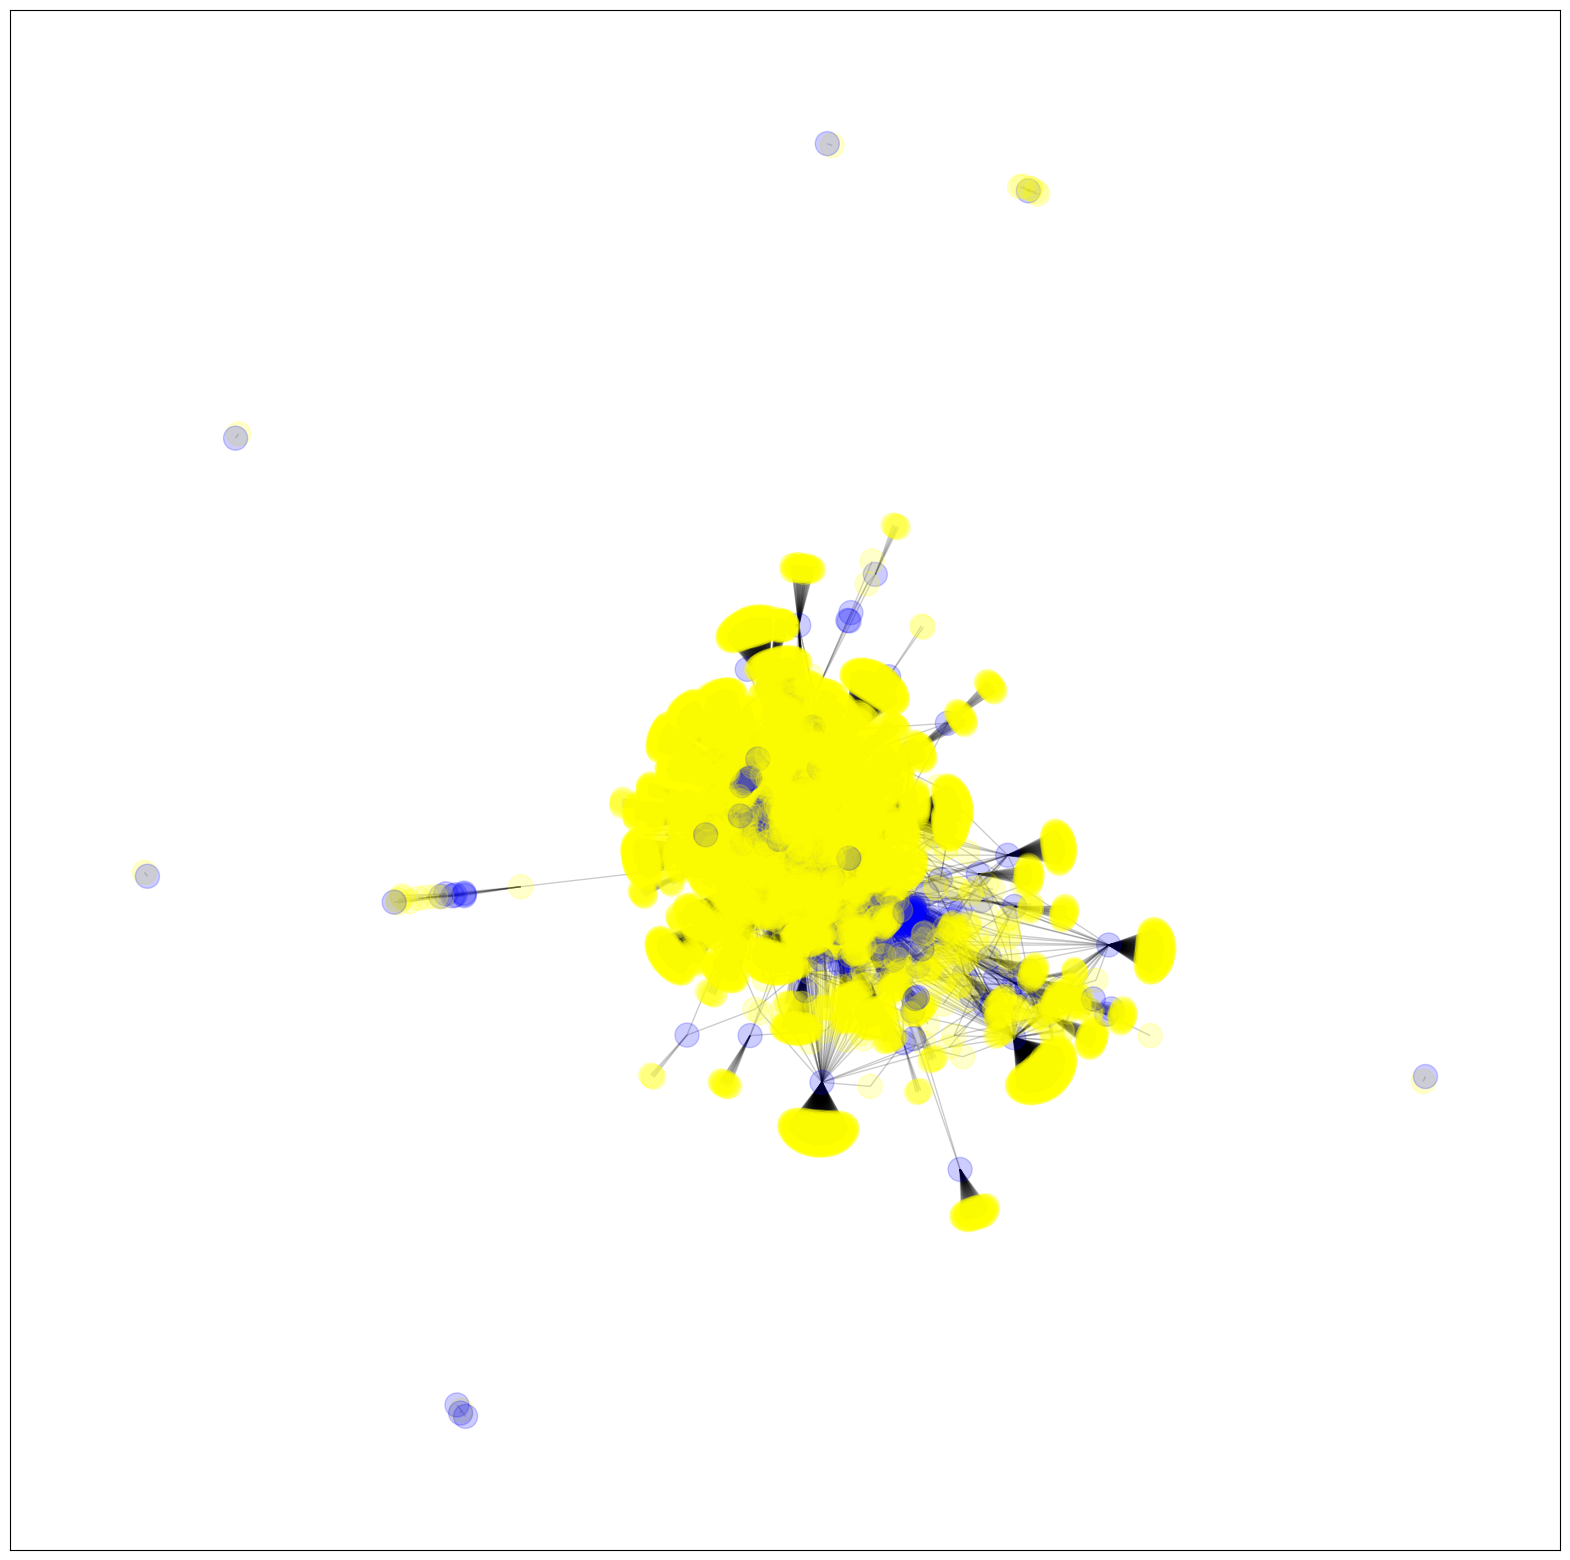

In [14]:
df_melted_deps = df_melted_deps[df_melted_deps[df_melted_deps.columns[2]] != 0]
df_melted_deps = df_melted_deps[df_melted_deps[df_melted_deps.columns[1]] != '']

display(df_melted_deps)
repo_id = df_melted_deps['repo_id'].to_list()
dep_name = df_melted_deps['dep_name'].to_list()
G = nx.from_pandas_edgelist(df_melted_deps, 
                            source='dep_name',
                            target='repo_id',
                            create_using=nx.MultiGraph())

nodes = G.nodes()
#display(nodes)
colors = ['blue' if n in repo_id else 'yellow' for n in nodes]


repo_id = df_melted_deps['repo_id'].to_list()
dep_name = df_melted_deps['dep_name'].to_list()
#colors = ['red' if nodes in repo_id else 'yellow']
#node_size = [depcount if n in dep_name else 120 if n in nodes]

fig, ax = plt.subplots(figsize=(20,20))
pos = nx.fruchterman_reingold_layout(G)
spos = nx.spring_layout(G, pos=pos, k=.4)
nx.draw_networkx(G, with_labels=False, node_color=colors, pos=spos, alpha=0.2, font_size=14, ax=ax)